# Building Micrograd
### Step 1: 
Create a class Value which is wrapper around Numbers
### Step 2: 
Add functionality of basic arithmatic operations
### Step 3: 
Add functionality of being able to remember children values, what operation was performed, its gradient
### Step 4:
Add functionality to calculate the 

In [29]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
            self.data = data
            self._prev = set(_children) # tuples to store what the last value was
            self._op = _op # stores what the last operation was
            self.label = label
            self.grad = 0.0
            self._backward = lambda: None
    
    def __repr__(self): # __repr__ function tells the internal state of an object and is triggered automatically or by using repr()
        return f"Value(Data={self.data})"
    
    def __add__(self, other):# invoked for '+' between two Value objects
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other): 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data ** other.data, (self, other), '**')
        
        def _backward():
            self.grad += other.data * (self.data ** (other.data - 1)) * out.grad
            other.grad += out.data * math.log(self.data) * out.grad
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        return self.data * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __rsub__(self, other):
        return other - self.data
    
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
        
    def tanh(self):
        x = 2 * self
        out = (x.exp() - 1) / (x.exp() + 1)
        out._prev = (self, )
        out._op = 'tanh'
        def _backward():
            a = out ** 2
            self.grad += (1 - a) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
          node._backward()


In [90]:
a = Value(0.6)
b = Value(0.3)
d = a + b
c = Value(3)
e = c * d
f = Value(0.1)
g = f ** e
h = g.tanh()
h.backward()


Value(Data=0.001995259667212273)


-0.004594242973025156

In [91]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

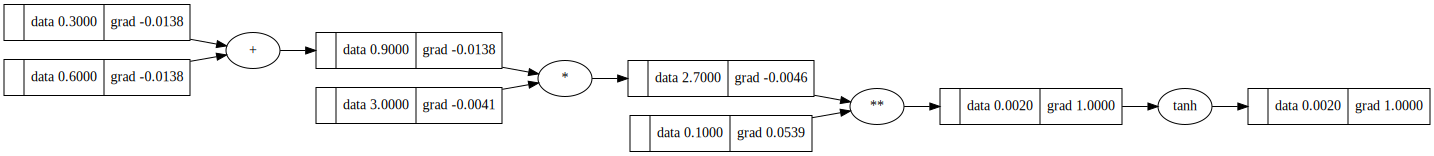

In [92]:
draw_dot(h)